# Time Series Analysis Ethereum Prices

In [602]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa import api as smt
plt.style.use('dark_background')
sns.set_theme(style="darkgrid")

We import the data

In [603]:
ethusd_data_raw = pd.read_csv("./2019-01-01_2020-12-11_ethereumprice_org.csv")
ethusd_data_raw.head()

,timestamp,open,high,low,close
0,1607644800,558.549922,undefined,undefined,undefined
1,1607558400,573.929015,574.8450094838519,549.1802302242935,558.5064466850556
2,1607472000,554.819245,577.7084307652647,531.187178148795,573.3586030033067
3,1607385600,591.130763,591.8160864000191,550.8678023008441,554.7577055601023
4,1607385540,591.384859,undefined,undefined,undefined


## Data Exploration
_________

In [604]:
# Cleaning undefined entries
ethusd_data = ethusd_data_raw[ethusd_data_raw['close'] != "undefined"][['timestamp', 'close']].astype(float)
ethusd_data.sort_values(by='timestamp', ascending=True, inplace=True)

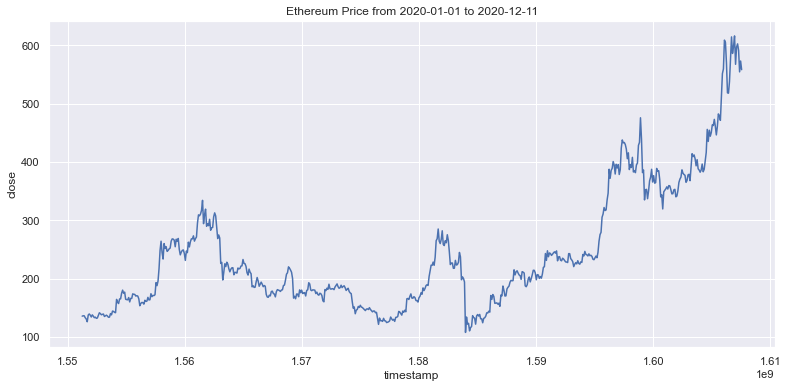

In [605]:
fig, ax = plt.subplots(figsize=(13,6))
ax.set_title("Ethereum Price from 2020-01-01 to 2020-12-11")
sns.lineplot(ax=ax, x="timestamp", y="close",
             data=ethusd_data)
plt.show()

In this graph, we can see the price of Ethereum has had high variation, but an overall uptrend.

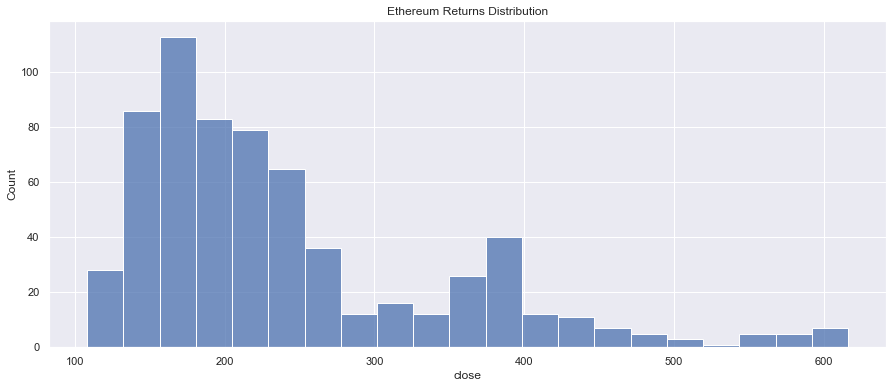

In [606]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Ethereum Returns Distribution")
sns.histplot(ax=ax, x='close', data=ethusd_data)
plt.show()

The dristribution of closing prices per day over time is right skewed, and so we know there are outliers on the high end of the distribution.

In [640]:
# Normalizing data by identifying returns
ethusd_data['diff'] = ethusd_data['close'] - ethusd_data['close'].shift(1)
ethusd_data['diff'] = ethusd_data['diff'] - ethusd_data['diff'].shift(1)
ethusd_data = pd.concat((ethusd_data['diff'].rolling(7).mean(), ethusd_data), join='inner', axis=1).dropna().reset_index(drop=True)
ethusd_data.columns = ethusd_data.columns = ["diff_ma"] + list(ethusd_data.columns)[1:]

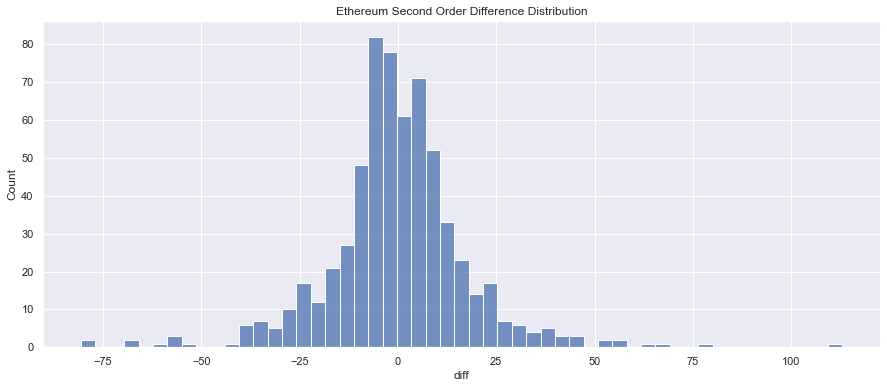

In [652]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Ethereum Second Order Difference Distribution")
sns.histplot(ax=ax, x='diff', data=ethusd_data)
plt.show()

The second order difference distribution looks perfectly normal

In [642]:
# Summary Statistics
ethusd_data[['close','diff']].describe()

,close,diff
count,630.000000,630.000000
mean,245.723177,-0.024424
std,105.519041,18.114360
min,108.131225,-80.535198
25%,171.700531,-7.958545
50%,213.464135,-0.718386
75%,286.985914,7.937068
max,616.374529,112.909123


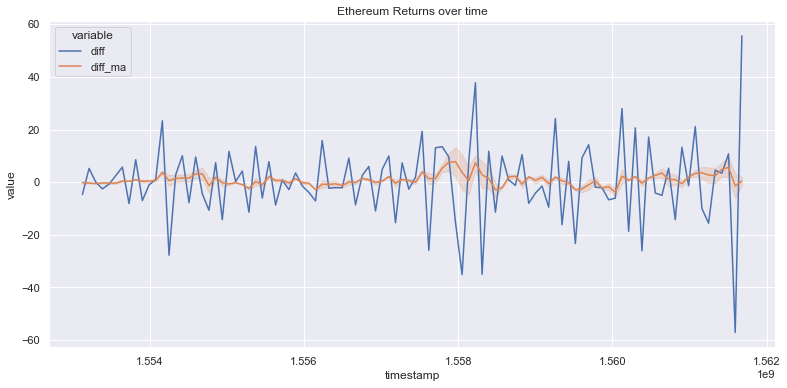

In [643]:
# We do this to condense multiple columns into two (variable and value)
data = pd.melt(ethusd_data[['timestamp','diff','diff_ma']][:100], ['timestamp'])
data['value'] = pd.to_numeric(data['value'])
data['timestamp'] = pd.to_numeric(data['timestamp'])

fig, ax = plt.subplots(figsize=(13,6))
ax.set_title("Ethereum Returns over time")
sns.lineplot(ax=ax, x="timestamp", y="value", hue="variable",
             data=data)
plt.show()

We know, based on observations from the graph, that our price time series is non-stationary. However, we want to test whether the second order difference time series is stationary. This will allow us to continue our analysis of Ethereum prices

In [644]:
print("Dickey-Fuller p: ", adfuller(ethusd_data['close'])[1])

Dickey-Fuller p:  0.8773912366309629


Our Dickey-Fuller test p value for Ethereum prices suggests that our pricing time series is not stationary

In [645]:
print("Dickey-Fuller p: ", adfuller(ethusd_data['diff'])[1])

Dickey-Fuller p:  2.4106808384820045e-14


For our second order difference time series, we have a stationary series

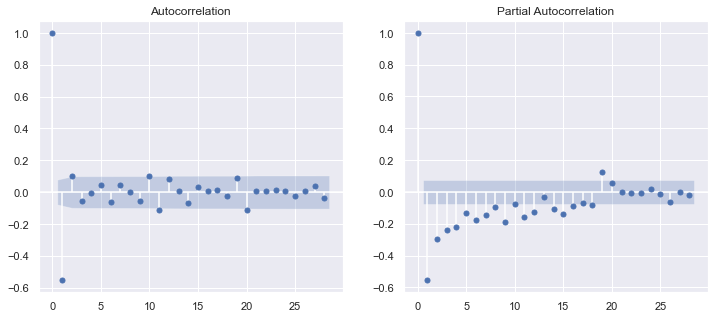

In [646]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
smt.graphics.plot_acf(ethusd_data['diff'], ax=ax[0])
smt.graphics.plot_pacf(ethusd_data['diff'], ax=ax[1])
plt.show()

- Autocorrelation - The effect of t-x in t
- Partial Autocorrelation - The exclussive effect of t-x in t


These allow us to identify the orders of our Moving Average and our Auto Regressive models respectively. Both graphs include error bands. Values within the error bands are not statistically significant, and can be interpreted as 0.

- For our Autocorrelation analysis only the first 2 values are beyond our error bands (ignoring our value t - 0)
- For our Partial Autocorrelation analysis we could say our first 12 values lie beyond our error bands

In [648]:
training_data = ethusd_data[:500]

model = ARIMA(training_data['close'], order=(9,2,2)).fit(disp=-1)
fitted_values = model.fittedvalues
ethusd_diff = training_data['close'][:500] - training_data['close'][:500].shift(1)
ethusd_diff = ethusd_diff - ethusd_diff.shift(1)

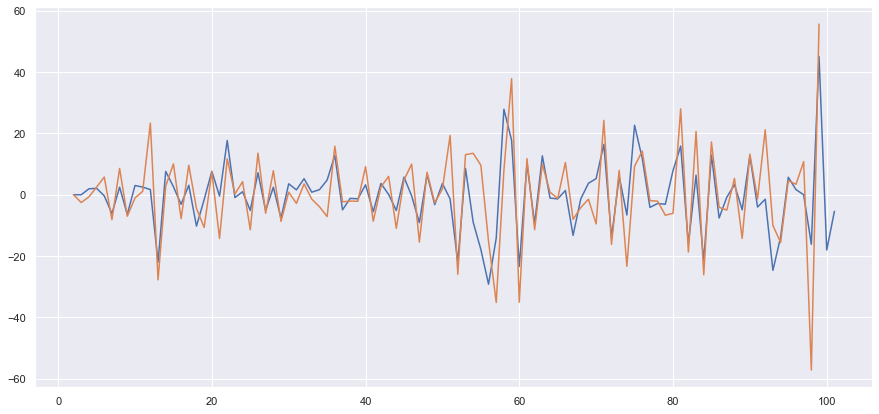

In [649]:
fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(fitted_values[:100])
ax.plot(ethusd_diff[:100])
plt.show()

Our model very closely follow the true time series

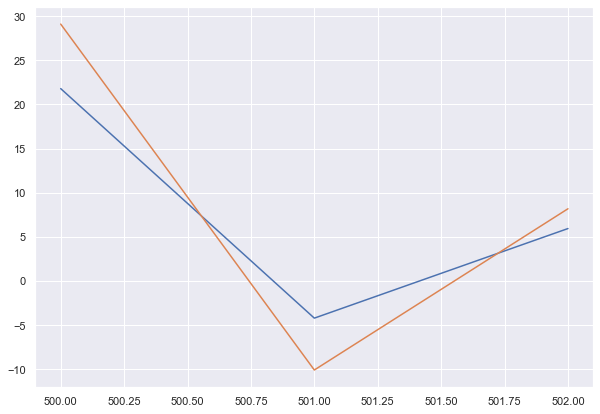

In [650]:
test_data = ethusd_data[498:]
test_data_diff = test_data['close'] - test_data['close'].shift(1)
test_data_diff = test_data_diff - test_data_diff.shift(1)
test_data_diff.dropna(inplace=True)

fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.plot(model.predict(500,502))
ax.plot(test_data_diff[:3])
plt.show()

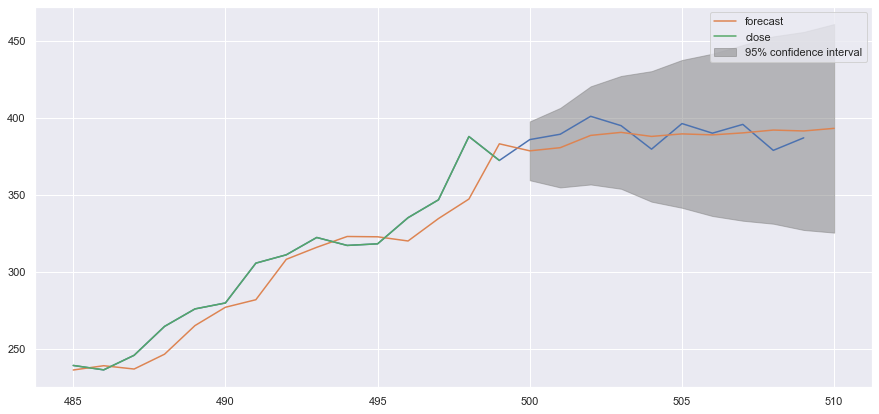

In [655]:
fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(ethusd_data['close'][485:510])
model.plot_predict(485,510, ax=ax)
plt.show()

Here we can see the predictive performance of our model over the next 11 days, and we can see it predicts the pricing somewhat accurately. The 95% confidence interval begins by spanning under \$50 for one day in the future and continues to spand over $150 for 10 days in the future.